In [1]:
# modules
# import basics
import os
import re
import csv
import json
import time
# import requests
import numpy as np
import pandas as pd

from collections import defaultdict
import itertools as it

from time import sleep
from datetime import datetime, timedelta 
from dotenv import load_dotenv
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
#from requests.auth import HTTPBasicAuth

# text processing dependencies
# from bs4 import BeautifulSoup
# from boilerpy3 import extractors

# mysql dependencies
import mysql.connector

In [2]:
# initialize variables

load_dotenv(override=True)

# mysql credentials
PASSWORD = os.getenv("PASSWORD")
USER = os.getenv("USER")

In [3]:
# connect to db
import mysql.connector

mydb = mysql.connector.connect(
  host="127.0.0.1",
  user=USER,
  password=PASSWORD,
  database="mpp21"
)

mycursor = mydb.cursor()

In [4]:
# read newspaper info 

newspapers = {}

with open('./newspapers-collected.csv', 'r') as f:
        reader = csv.reader(f)
        for r in reader:
            newspapers[r[0]] = r[1]

In [5]:
# db methods
def select_within_range(curs, db, n):
    
    curs.execute("SELECT article_id, title, date, metadata FROM articles WHERE newspaper = '" + n + "' AND date >= '" + timeframe_start + "' AND date <= '" + timeframe_end + "'") 
    
    arts = {}
    result = curs.fetchall()
    for r in result:
        arts[r[0]] = {
            "title": r[1],
            "date": r[2], 
            "wordCount": json.loads(r[3])["wordCount"]
        }
    
    return arts

In [6]:
weeks = []

timeframe_start = datetime.date(datetime(2010,12,27)) # monday
timeframe_end = datetime.date(datetime(2020,12,31))

dt = timeframe_start

while dt <= timeframe_end:
    
    weeks.append((dt, dt + timedelta(days=6))) # (start, end)
    dt += timedelta(days=7) # move to next week

In [7]:
len(weeks)

523

In [8]:
print(weeks[0])
print(weeks[-1])

(datetime.date(2010, 12, 27), datetime.date(2011, 1, 2))
(datetime.date(2020, 12, 28), datetime.date(2021, 1, 3))


In [9]:
timeframe_start = '2011-01-01'
timeframe_end = '2020-12-31'

# REMOVE IDENTICAL DUPLICATES

In [10]:
def group_by_week(n):
    
    group = {}

    ctr = 1 # week

    for w in range(len(weeks)):
        group["week_" +str(w + 1) + ""] = []

    for week in weeks:
        for i in articles[n].keys():

            if articles[n][i]["date"] >= week[0] and articles[n][i]["date"] <= week[1]:
                dc = {"id": i,
                      "date": articles[n][i]["date"],
                      "title": articles[n][i]["title"]                    
                }
                group["week_" +str(ctr) + ""].append(dc)
        ctr += 1
        
    return group

In [11]:
# get articles for newspaper n in range

articles = {}
for n in newspapers.keys():
    articles[n] = {}


In [12]:
for n in articles.keys():
    articles[n] = select_within_range(mycursor, mydb, n)

In [13]:
groups = {}
for n in articles.keys():
    groups[n] = group_by_week(n)

In [14]:
# def get_cosine_similarity_week(docs): # docs = list of titles

#     # doc term matrix
#     count_vectorizer = CountVectorizer(stop_words='english')
#     count_vectorizer = CountVectorizer()
#     sparse_matrix = count_vectorizer.fit_transform(docs)

#     return cosine_similarity(sparse_matrix, sparse_matrix)

def cos_sim(x, y):
    
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform([x, y])

    return cosine_similarity(sparse_matrix, sparse_matrix)[0] 
    # returns first row i.e. x vs y (second is y vs x)

In [15]:
def display_aggregated_similarity(agg):
    
    #plt.figure(figsize=(8,8),facecolor='red',edgecolor='blue')
    fig,ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    
    a = list(agg)
    ax.hist(a, bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
            histtype="step",  color="#87111d", alpha=0.45, edgecolor="#87111d", linewidth=3.2)
    #ax.set_title("histogram of aggregated cosine similarity for 6 months (all newspapers)", fontsize=24)
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax.set_xlabel('cosine similarity score', fontsize=20)
    ax.set_ylabel('frequency of similarity score values', fontsize=20)
    ax.set_yticks([0,10,100,1000,10000])
    ax.set_yticklabels([0,10,100,1000,10000], fontsize=20)
    ax.set_xticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize=20) 
    plt.yscale("log")   

    #plt.xlim(40, 160)
#     plt.ylim(0, 30000)
   ## ax.spines['top'].set_visible(False)
    ##ax.spines['right'].set_visible(False)

    #plt.grid(True)
    plt.show()
    
    return 

In [16]:
def get_similarities_over_threshold(n):

    cosines = []
    tres_arts = []
    
    title_sims = []#defaultdict(lambda: [])

    for w in groups[n].keys(): # for each week
        pairs_in = []
        for a1 in groups[n][w]: # for articles within that week
            for a2 in groups[n][w]:
                try:
                    cs = cos_sim(a1["title"], a2["title"])
                    if round(cs[1], 2) >= 0.7: ####== 1.0:#>= 0.7:

                        if a1["id"] != a2["id"]:

                            if sorted((a1["id"], a2["id"])) not in pairs_in:
                
                                pairs_in.append(sorted((a1["id"], a2["id"])))
                                cosines.append(cs[1])
                                tres_arts.append((a1, a2))
                                

                                title_sims.append([a1["id"], a2["id"]])

                except:
                    print("some error")
                    pass

    return cosines, tres_arts, title_sims

In [20]:
# update record in table as duplicate

def update_tone(curs, db, dup, aID):

    # compile query
    insertQuery = "UPDATE articles SET is_privacy = (%s) WHERE article_id = (%s)"
    insertValues = (dup, aID)
    
    curs.execute(insertQuery, insertValues)
    
    db.commit() # commit query



In [36]:
def sel_aid(curs, db, n):
    
    curs.execute("SELECT article_id FROM articles WHERE newspaper = '" + n + "' AND year(DATE)!= 2010") 
    
    arts = []
    result = curs.fetchall()
    for r in result:
        arts.append(r[0])
    return arts

In [44]:
# # update all

# # sel all
# arids = {}
# for n in newspapers.keys():
#     arids[n] = sel_aid(mycursor, mydb, n)
    
#     print(n, ":", len(arids[n]))
    
# # update all

In [43]:
# for n in newspapers.keys():
#     print(n)
#     for i in arids[n]:
#         update_tone(mycursor, mydb, "", i)

In [22]:
duplicates = {}
cosines = {}
articles_threshold = {}

In [19]:
def get_max_in_entry(e, n):
    
    dates = {}
    
    for i in e:
        dates[i] = articles[n][i]["date"]

    if len(set(dates.values())) > 1: # if they have the same date
        #print(dates)
        return max(dates, key=dates.get)
    
    else:
        word_counts = {}
        # second step (word count)
        for i in e: # each group
            word_counts[i] = articles[n][i]["wordCount"]
        return max(word_counts, key=word_counts.get)


def get_originals(l, n): # list
    
    originals = []
    
    for entry in l: # each group
        correct = get_max_in_entry(entry, n)
        
        originals.append(correct)
        

    return originals

def get_duplicates(l, o):
    
    ds = []
    
    for i in l:
        for j in i:
            if j not in o:
                ds.append(j)
    return ds

In [69]:
n = "DT"
#for n in newspapers.keys():
print(n)

cosines_threshold, threshold_articles, tsims = get_similarities_over_threshold(n)
cosines[n] = cosines_threshold
articles_threshold[n] = threshold_articles
fl = get_list_of_duplicates(tsims)
# for x in fl:
#     print(x)
valid = verify_duplicate_correctness(fl, threshold_articles)


originals = get_originals(fl, n)
duplicates[n] = get_duplicates(fl, originals)


print(len(duplicates[n]), "duplicates to be removed.")


DT
1380 1363
1031 duplicates to be removed.


In [54]:
def verify_duplicate_correctness(a, b): # given the final lists of duplicates 
            # e.g. [a, b, c, d] where b, c, d are duplicates of a
    
    combinations = 0

    for i in a: # for each list
        combinations += len(list(it.combinations(i, 2))) # get all possible combinations of two
        
    print(combinations, len(b))
    return combinations == len(b)

In [72]:
def get_list_of_duplicates(tims):
    
    new_list = {}
    
    ## creates a dictionary of all articles that have a duplicate

    for i in tims: # for each pair that resulted in a similarity index above threshold
        for j in i: # take each element # the first element
            new_list[j] = [] # create a list of all its matches
            for l in tims: # go through the rest of the list
                if j in l: # find all its matches
                    [new_list[j].append(x) for x in l] # these are all the matches of
                                                        # article j, including j (so appending a pair)

    for i in new_list.keys(): # for all articles that have a duplicate
        new_list[i] = set(new_list[i]) # get each duplicate only once
        
    final_list = []

    for i in new_list.keys(): # for each article with a duplicate 
        if sorted(list((new_list[i]))) not in final_list: # only get final lists (i.e. remove counting the same groups twice)
                                        # what this essentially does is if you have [a, b] and [b, a]
                                        # where b is a duplicate for b and the other way around
                                        # we only count the pair once
            final_list.append(sorted(set(list((new_list[i]))))) # set
    
    return final_list

In [55]:
fl = get_list_of_duplicates(tsims)
valid = verify_duplicate_correctness(fl, threshold_articles)


originals = get_originals(fl, n)
duplicates[n] = get_duplicates(fl, originals)


print(len(duplicates[n]), "duplicates to be removed.")

1380 1363
1031 duplicates to be removed.


In [60]:
maxxx = 0
for i in fl:
    if len(i) > maxxx:
        maxxx = len(i)
print(maxxx)

12


In [61]:
uniques = []
for i in fl:
    for j in i:
        uniques.append(j)
len(uniques)

1855

In [62]:
len(set(uniques))

1843

In [58]:
combinations = 0

for i in fl: # for each list
    print(i)
    combinations += len(list(it.combinations(i, 2))) # get all possible combinations of two


['DT_2335', 'DT_2336', 'DT_2337']
['DT_1287', 'DT_1288', 'DT_1289']
['DT_1642', 'DT_1643', 'DT_1644']
['DT_3284', 'DT_3285']
['DT_2087', 'DT_2088']
['DT_4868', 'DT_4869']
['DT_1142', 'DT_1143', 'DT_1144']
['DT_1637', 'DT_1638']
['DT_2554', 'DT_2555', 'DT_2556']
['DT_1257', 'DT_1258', 'DT_1259']
['DT_5479', 'DT_5480']
['DT_5848', 'DT_5849', 'DT_5850']
['DT_6139', 'DT_6143']
['DT_5483', 'DT_5484', 'DT_5485']
['DT_2473', 'DT_2474']
['DT_5014', 'DT_5015', 'DT_5016', 'DT_5017']
['DT_6106', 'DT_6107']
['DT_6385', 'DT_6386']
['DT_2200', 'DT_2201', 'DT_2202']
['DT_5103', 'DT_5104']
['DT_5375', 'DT_5376']
['DT_3282', 'DT_3283']
['DT_3385', 'DT_3386']
['DT_1229', 'DT_1230', 'DT_1231']
['DT_5826', 'DT_5827']
['DT_1192', 'DT_1193']
['DT_2500', 'DT_2501', 'DT_2502']
['DT_3206', 'DT_3207', 'DT_3208', 'DT_3209', 'DT_3210', 'DT_3211']
['DT_3432', 'DT_3433', 'DT_3434', 'DT_3435', 'DT_3436', 'DT_3437']
['DT_2189', 'DT_2190']
['DT_2348', 'DT_2349']
['DT_894', 'DT_895']
['DT_4989', 'DT_4990']
['DT_4295', 

In [21]:
# good but don't update
# for n in newspapers.keys():
#     print(n, "updated:", len(duplicates[n]))
#     pd.DataFrame(cosines[n]).to_csv("cosines_final/cosines_"+ n +"_final.csv", header=None, index=None)
    
#     for i in duplicates[n]:
#         update_tone(mycursor, mydb, "duplicate", i)

In [27]:
#pd.DataFrame(cosines[n]).to_csv("cosines_final/cosines_"+ n +"_final.csv", header=None, index=None)

In [34]:
for i in originals:
    for j in duplicates["TG"]:
        for k in j:
            if i == k:
                print(i, k)

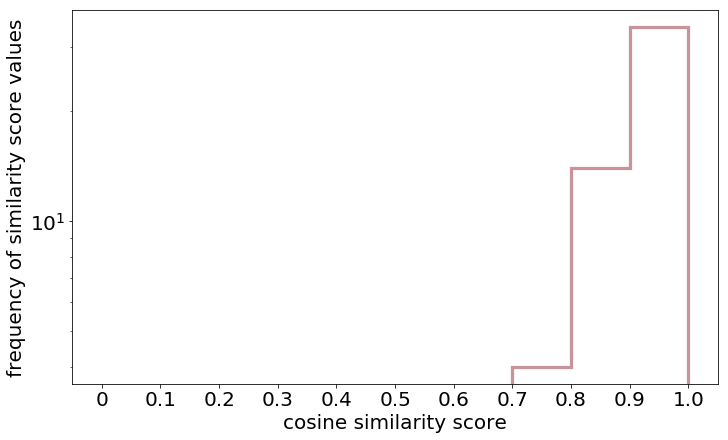

In [316]:
display_aggregated_similarity(cosines[n])

# REMOVE SIMILAR DUPLICATES

In [339]:
coses = {}
all_coses = []
for n in newspapers.keys():
    with open("./cosines_"+n+".csv", 'r') as f:
            reader = csv.reader(f)
            coses[n] = []
            for r in reader:
                coses[n].append(float(r[0]))
                all_coses.append(float(r[0]))

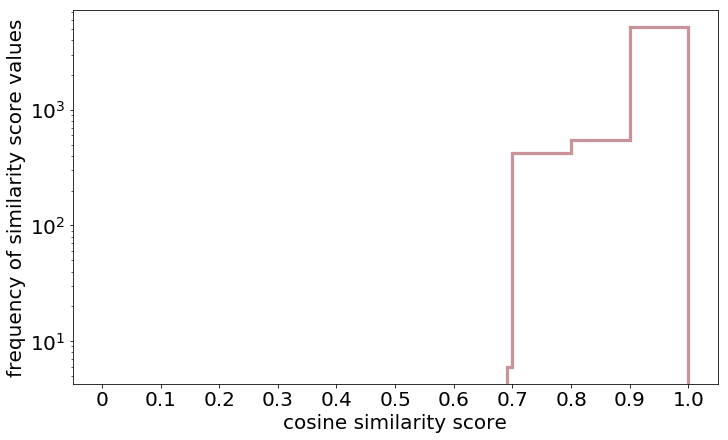

In [345]:
fig,ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    

ax.hist(all_coses, bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.69,0.7,0.8,0.9,1.0], 
        histtype="step",  color="#87111d", alpha=0.45, edgecolor="#87111d", linewidth=3.2)

# ax.hist(np.array(coses["USA"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="yellow", linewidth=3.2)

# ax.hist(np.array(coses["AFR"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="green", linewidth=3.2)

# ax.hist(np.array(coses["SMH"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="blue", linewidth=3.2)

# ax.hist(np.array(coses["NZH"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="lightblue", linewidth=3.2)

# ax.hist(np.array(coses["TDP"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="darkgreen", linewidth=3.2)

# ax.hist(np.array(coses["DT"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="brown", linewidth=3.2)

# ax.hist(np.array(coses["TG"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="black", linewidth=3.2)

# ax.hist(np.array(coses["TS"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="gray", linewidth=3.2)

# ax.hist(np.array(coses["GM"]), bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 
#         histtype="step",  color="#87111d", alpha=0.45, edgecolor="#87111d", linewidth=3.2)

#ax.set_title("histogram of aggregated cosine similarity for 6 months (all newspapers)", fontsize=24)
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xlabel('cosine similarity score', fontsize=20)
ax.set_ylabel('frequency of similarity score values', fontsize=20)
ax.set_yticks([0,10,100,1000,10000])
ax.set_yticklabels([0,10,100,1000,10000], fontsize=20)
ax.set_xticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize=20) 
plt.yscale("log")   

#plt.xlim(40, 160)
#     plt.ylim(0, 30000)
## ax.spines['top'].set_visible(False)
##ax.spines['right'].set_visible(False)

#plt.grid(True)
plt.show()